In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline


### EDA

데이터

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
original_data = pd.read_csv("data/original_data.csv")

통계적 특성 파악

In [4]:
# 레코드 수 
total = train.shape[0] + test.shape[0]
print("Train Data와 Test Data의 총 레코드 수: {}행".format(total))
print("Train Data: {0}행, 총 레코드의 {1:.4f}%".format(train.shape[0], train.shape[0]/total))
print("Test Data: {0}행, 총 레코드의 {1:.4f}%".format(test.shape[0], test.shape[0]/total))

print("\nOriginal Data의 레코드 수: {}행".format(original_data.shape[0]))

Train Data와 Test Data의 총 레코드 수: 365216행
Train Data: 219129행, 총 레코드의 0.6000%
Test Data: 146087행, 총 레코드의 0.4000%

Original Data의 레코드 수: 284807행


In [5]:
# 피처 수

print("Train Data: {}개".format(len(train.columns[0:-1])))
print("Test Data: {}개".format(len(test.columns)))
print("Original Data: {}개".format(len(original_data.columns[0:-1])))
set1 = set(train.columns[0:-1])
set2 = set(test.columns)
set3 = set(original_data.columns[0:-1])

print("\nTrain Data의 피처와 Test Data 피처 차집합: {}".format(list(set1-set2)))
print("Train Data의 피처와 Original Data 피처 차집합: {}".format(list(set1-set3)))
print("Train Data의 피처와 Test Data 공통 피처 개수: {}".format(len(list(set1&set2))
))



Train Data: 31개
Test Data: 31개
Original Data: 30개

Train Data의 피처와 Test Data 피처 차집합: []
Train Data의 피처와 Original Data 피처 차집합: ['id']
Train Data의 피처와 Test Data 공통 피처 개수: 31


In [6]:
# Original Data와 Train Data를 Concat
train_combined = pd.concat([train, original_data], axis=0, ignore_index=True)
print("Train_Combined Data에서 중복되는 제거 대상 행: {}개".format(train_combined.duplicated().sum()))

Train_Combined Data에서 중복되는 제거 대상 행: 1081개


In [7]:
# Train_Combined Data 중복 행 제거
train_combined.drop_duplicates(inplace=True, ignore_index=True)

In [8]:
# Train_Combined Data와 Test Data의 'id' 컬럼 삭제
train_combined.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [9]:
# 결측치 확인 및 처리

print("Train_Combined Data의 결측값: {}개".format(train_combined.isna().sum().sum()))
print("Train_Combined Data에서 Amount(결제금액)가 0인 행: {}개".format(train_combined[train_combined['Amount'] == 0].shape[0]))
print("Test Data의 결측값: {}개".format(test.isna().sum().sum()))
print("Test Data에서 Amount(결제금액)가 0인 행: {}개".format(test[test['Amount'] == 0].shape[0]))


Train_Combined Data의 결측값: 0개
Train_Combined Data에서 Amount(결제금액)가 0인 행: 3654개
Test Data의 결측값: 0개
Test Data에서 Amount(결제금액)가 0인 행: 1380개


In [10]:
# 각각의 Data에서 Amount(결제금액)가 0인 행 제거
train_combined.drop(train_combined[train_combined['Amount'] == 0].index, inplace=True)
test.drop(test[test['Amount'] == 0].index, inplace=True)

In [11]:
# 확인
print("Train_Combined Data에서 Amount(결제금액)가 0인 행: {}개".format(train_combined[train_combined['Amount'] == 0].shape[0]))
print("Test Data에서 Amount(결제금액)가 0인 행: {}개".format(test[test['Amount'] == 0].shape[0]))

Train_Combined Data에서 Amount(결제금액)가 0인 행: 0개
Test Data에서 Amount(결제금액)가 0인 행: 0개


In [12]:
# 타겟 비율
print("Train Data의 Genuine Transaction(클래스 0): {}건".format(train_combined['Class'].value_counts()[0]))
print("Train Data의 Fraudulent Transaction(클래스 1): {}건".format(train_combined['Class'].value_counts()[1]))

Train Data의 Genuine Transaction(클래스 0): 498296건
Train Data의 Fraudulent Transaction(클래스 1): 905건


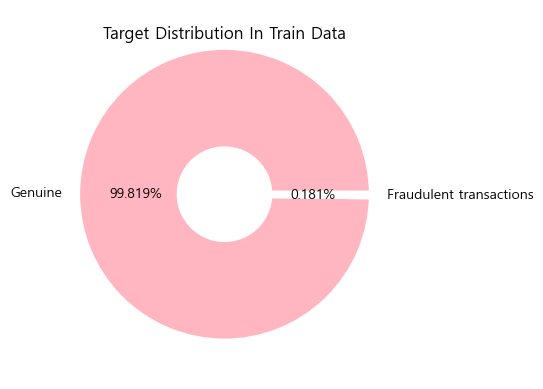

In [13]:
# Train_Combined Data의 Target 비율 확인

custom_colors = ["#FFB6C1", "#58D3F7"]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(train_combined['Class'].value_counts(normalize=True).values
        ,labels=['Genuine', 'Fraudulent transactions']
        ,colors=custom_colors
        ,autopct='%0.3f%%'
        ,wedgeprops=wedgeprops)
plt.title("Target Distribution In Train Data"
          ,y = 0.9)
plt.show()

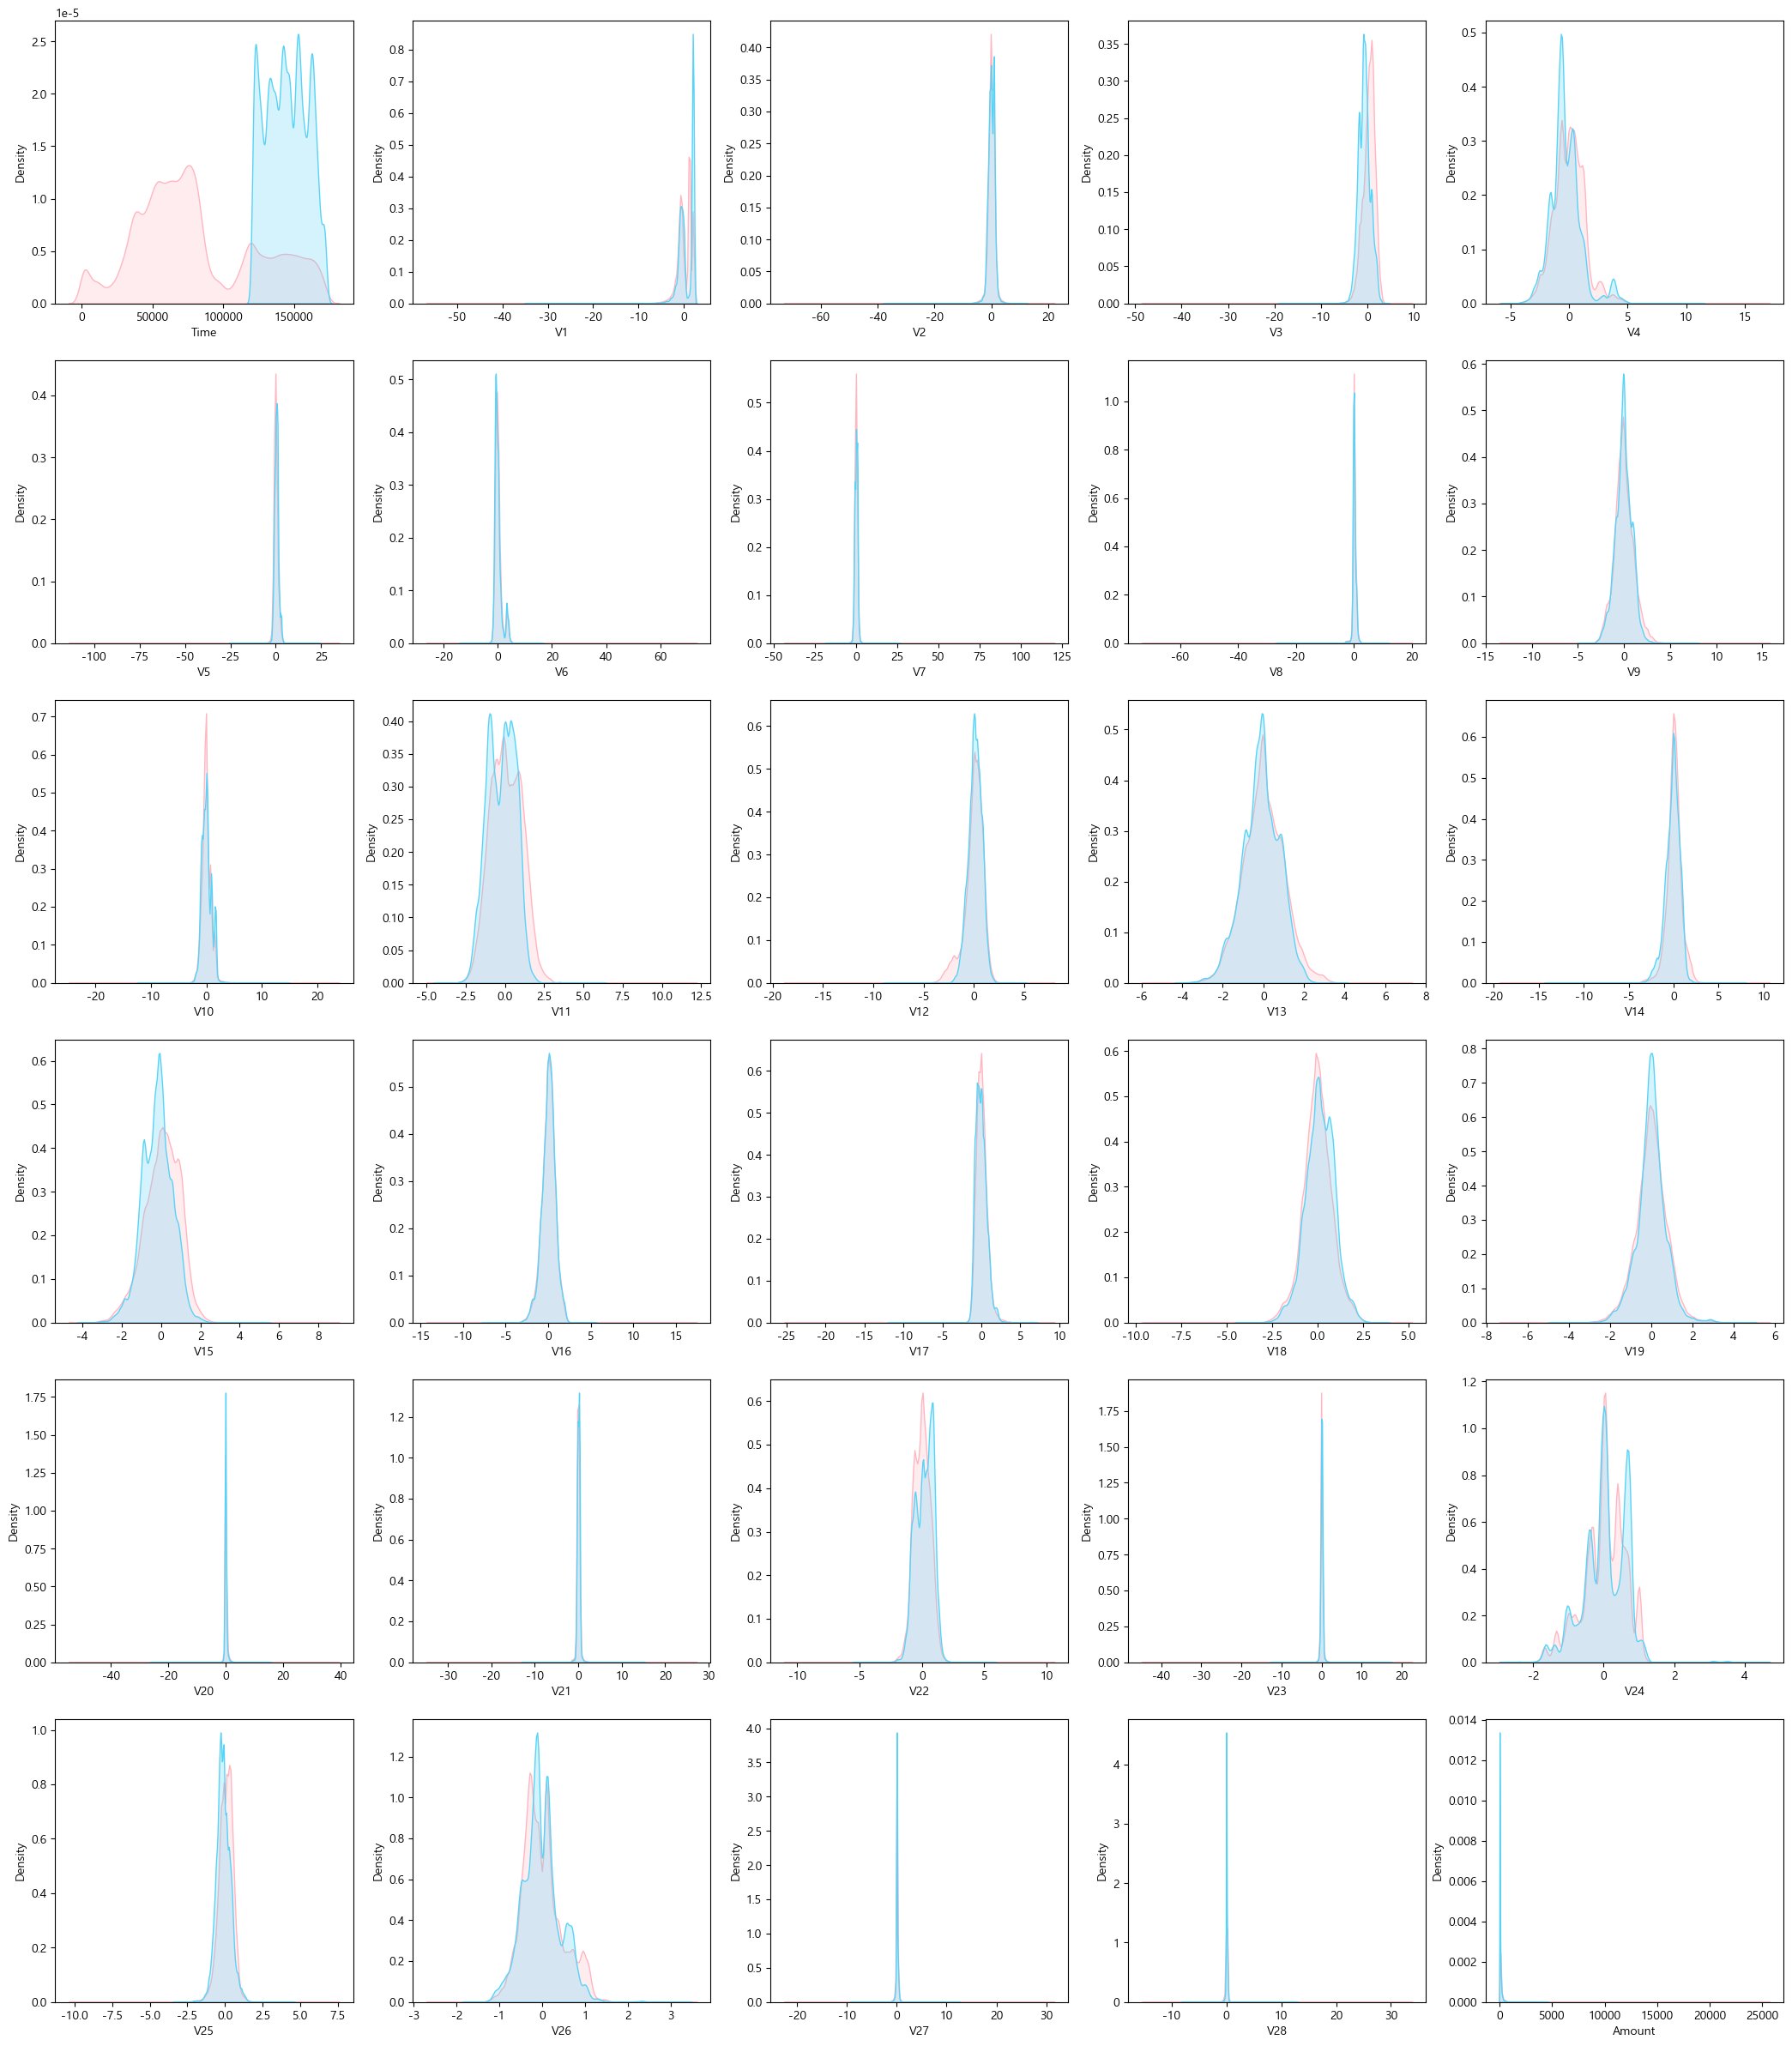

In [14]:
# Train_Combined/Test Data의 Feature별 밀도플롯 

continuous_cols = train_combined.iloc[:, :-1].columns.tolist()

fig, axs = plt.subplots(figsize=(26, 30), nrows= 6, ncols=5)

for i, feature in enumerate(continuous_cols):
    row = int(i/5)
    col= i%5
    sns.kdeplot(x=feature, data=train_combined.iloc[:, :-1], fill=True, color ="#FFB6C1", ax=axs[row][col])
    sns.kdeplot(x=feature, data=test, fill=True, color ="#58D3F7", ax=axs[row][col])

Time

Text(0.5, 1.0, "Train의 'Time' vs Test'Time'")

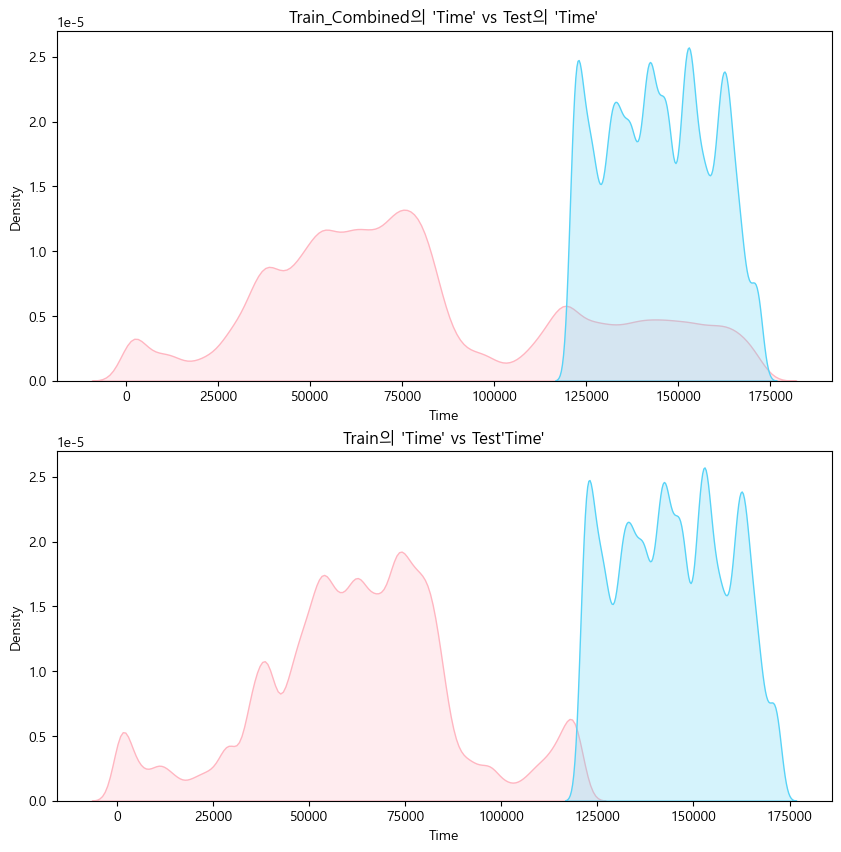

In [15]:
# Train Data에 Original Data를 더한 이유


fig, axs = plt.subplots(2, 1, figsize=(10, 10))

sns.kdeplot(x='Time', data=train_combined, fill=True, color="#FFB6C1", ax=axs[0])
sns.kdeplot(x='Time', data=test, fill=True, color="#58D3F7", ax=axs[0])
axs[0].set_title("Train_Combined의 'Time' vs Test의 'Time'")


sns.kdeplot(x='Time', data=train, fill=True, color="#FFB6C1", ax=axs[1])
sns.kdeplot(x='Time', data=test, fill=True, color="#58D3F7", ax=axs[1])
axs[1].set_title("Train의 'Time' vs Test'Time'")


Text(0.5, 1.0, 'Genuine VS Fraudulent')

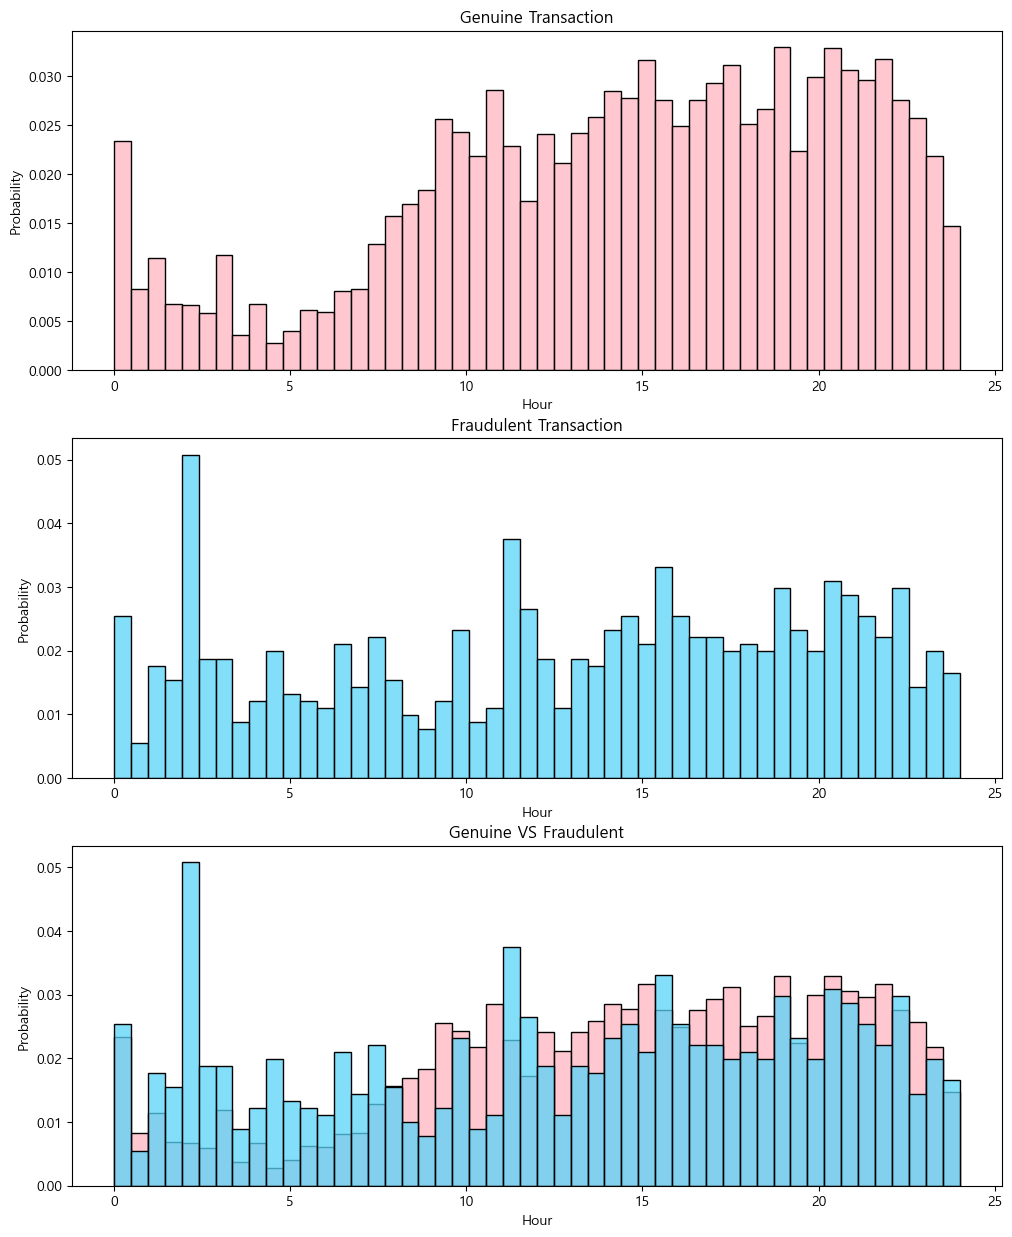

In [16]:
# Time을 24시간으로

train_combined['Hour'] = train_combined['Time'].apply(lambda x : (x-86400)/3600 if x>86400 else (x/3600))

fig, axs = plt.subplots(3, 1, figsize=(12, 15))

sns.histplot(data=train_combined['Hour'][train_combined['Class']==0], bins=50, binrange=(0, max(train_combined['Hour'])), stat='probability', color='#FFB6C1', ax=axs[0])
sns.histplot(data=train_combined['Hour'][train_combined['Class']==1], bins=50, binrange=(0, max(train_combined['Hour'])), stat='probability', color='#58D3F7', ax=axs[1])
sns.histplot(data=train_combined['Hour'][train_combined['Class']==0], bins=50, binrange=(0, max(train_combined['Hour'])), stat='probability', color='#FFB6C1', ax=axs[2])
sns.histplot(data=train_combined['Hour'][train_combined['Class']==1], bins=50, binrange=(0, max(train_combined['Hour'])), stat='probability', color='#58D3F7', ax=axs[2])
axs[0].set_title("Genuine Transaction")
axs[1].set_title("Fraudulent Transaction")
axs[2].set_title("Genuine VS Fraudulent")

In [17]:
# Train_Combined 데이터의 Time변수를 4개의 시간대로 레이블링
train_combined['Time_cut'] = pd.cut(train_combined['Hour'], bins =[0, 6, 12, 18, 24], labels=['early_morning', 'morning', 'afternoon', 'evening'], include_lowest=True)
train_combined['Time_cut'].value_counts()

evening          169174
afternoon        167997
morning          111778
early_morning     50252
Name: Time_cut, dtype: int64

In [18]:
# Test 데이터의 Time변수를 4개의 시간대로 레이블링

test['Hour'] = test['Time'].apply(lambda x : (x-86400)/3600 if x>86400 else (x/3600))
test['Time_cut'] = pd.cut(test['Hour'], bins =[0, 6, 12, 18, 24], labels=['early_morning', 'morning', 'afternoon', 'evening'], include_lowest=True)
test['Time_cut'].value_counts()

afternoon        63392
evening          53972
morning          27343
early_morning        0
Name: Time_cut, dtype: int64

In [19]:
# 4개의 시간대 원-핫 인코딩
train_timeline = pd.get_dummies(train_combined['Time_cut'])
train_combined = pd.concat([train_combined, train_timeline], axis=1)
test_timeline = pd.get_dummies(test['Time_cut'])
test = pd.concat([test, test_timeline], axis=1)

In [20]:
# 이외의 Time 변수 정리
train_combined.drop(columns=['Time', 'Time_cut'], axis=1, inplace=True)
test.drop(columns=['Time', 'Time_cut'], axis=1, inplace=True)

'Amount'

In [21]:
train_combined['Amount'].describe()

count    499201.000000
mean         79.413621
std         213.758926
min           0.000045
25%           6.000000
50%          22.470000
75%          74.450000
max       25691.160000
Name: Amount, dtype: float64

Text(0.5, 1.0, 'Genuine VS Fraudulent')

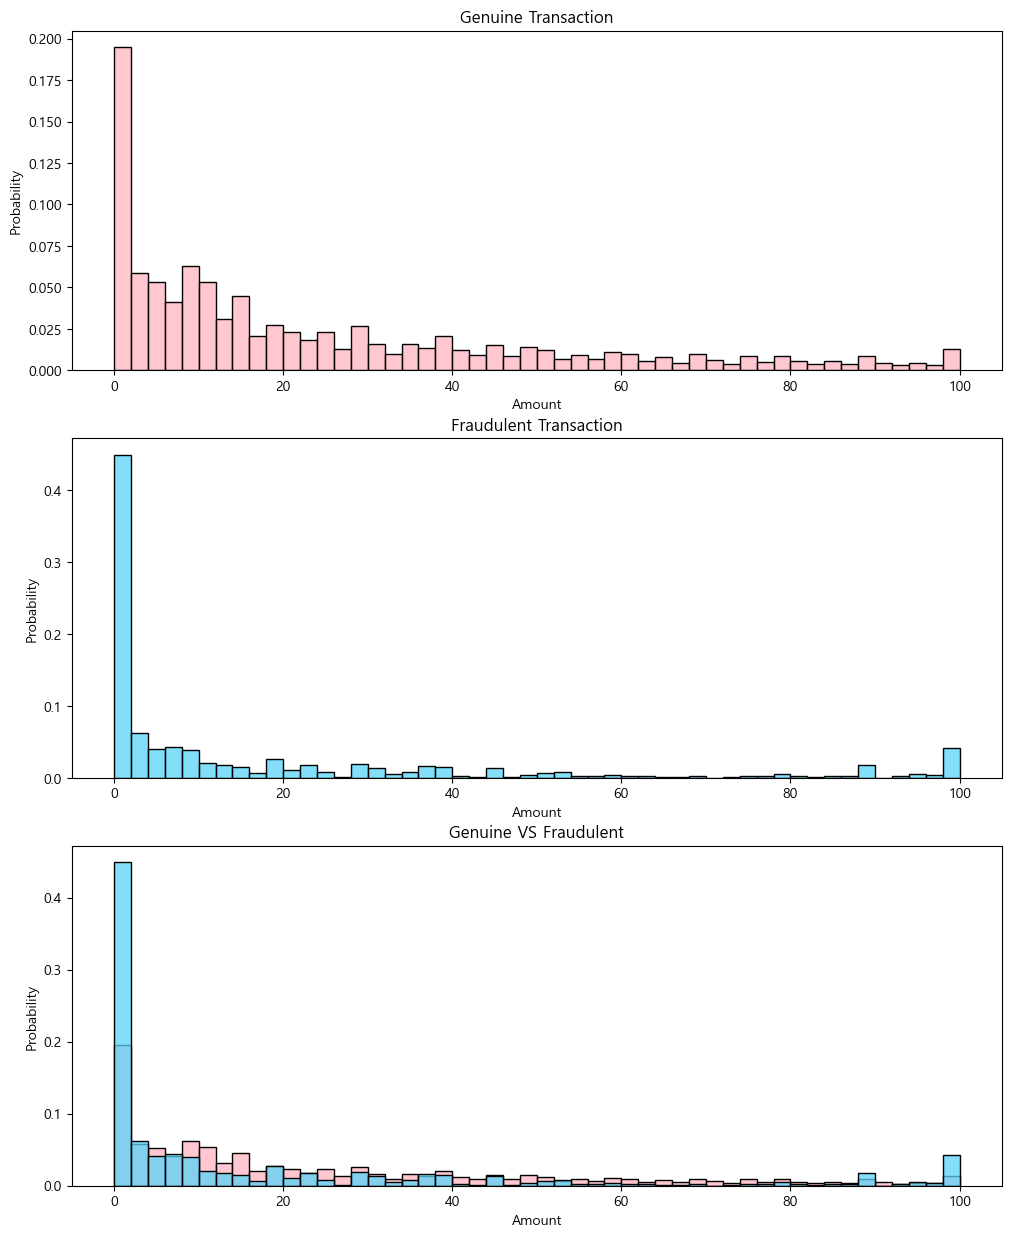

In [22]:
# Train_Combined 데이터의 Amount 분포 비교

fig, axs = plt.subplots(3, 1, figsize=(12, 15))

sns.histplot(data=train_combined['Amount'][train_combined['Class']==0], bins=50, binrange=(0, 100), stat='probability', color='#FFB6C1', ax=axs[0])
sns.histplot(data=train_combined['Amount'][train_combined['Class']==1], bins=50, binrange=(0, 100), stat='probability', color='#58D3F7', ax=axs[1])
sns.histplot(data=train_combined['Amount'][train_combined['Class']==0], bins=50, binrange=(0, 100), stat='probability', color='#FFB6C1', ax=axs[2])
sns.histplot(data=train_combined['Amount'][train_combined['Class']==1], bins=50, binrange=(0, 100), stat='probability', color='#58D3F7', ax=axs[2])
axs[0].set_title("Genuine Transaction")
axs[1].set_title("Fraudulent Transaction")
axs[2].set_title("Genuine VS Fraudulent")

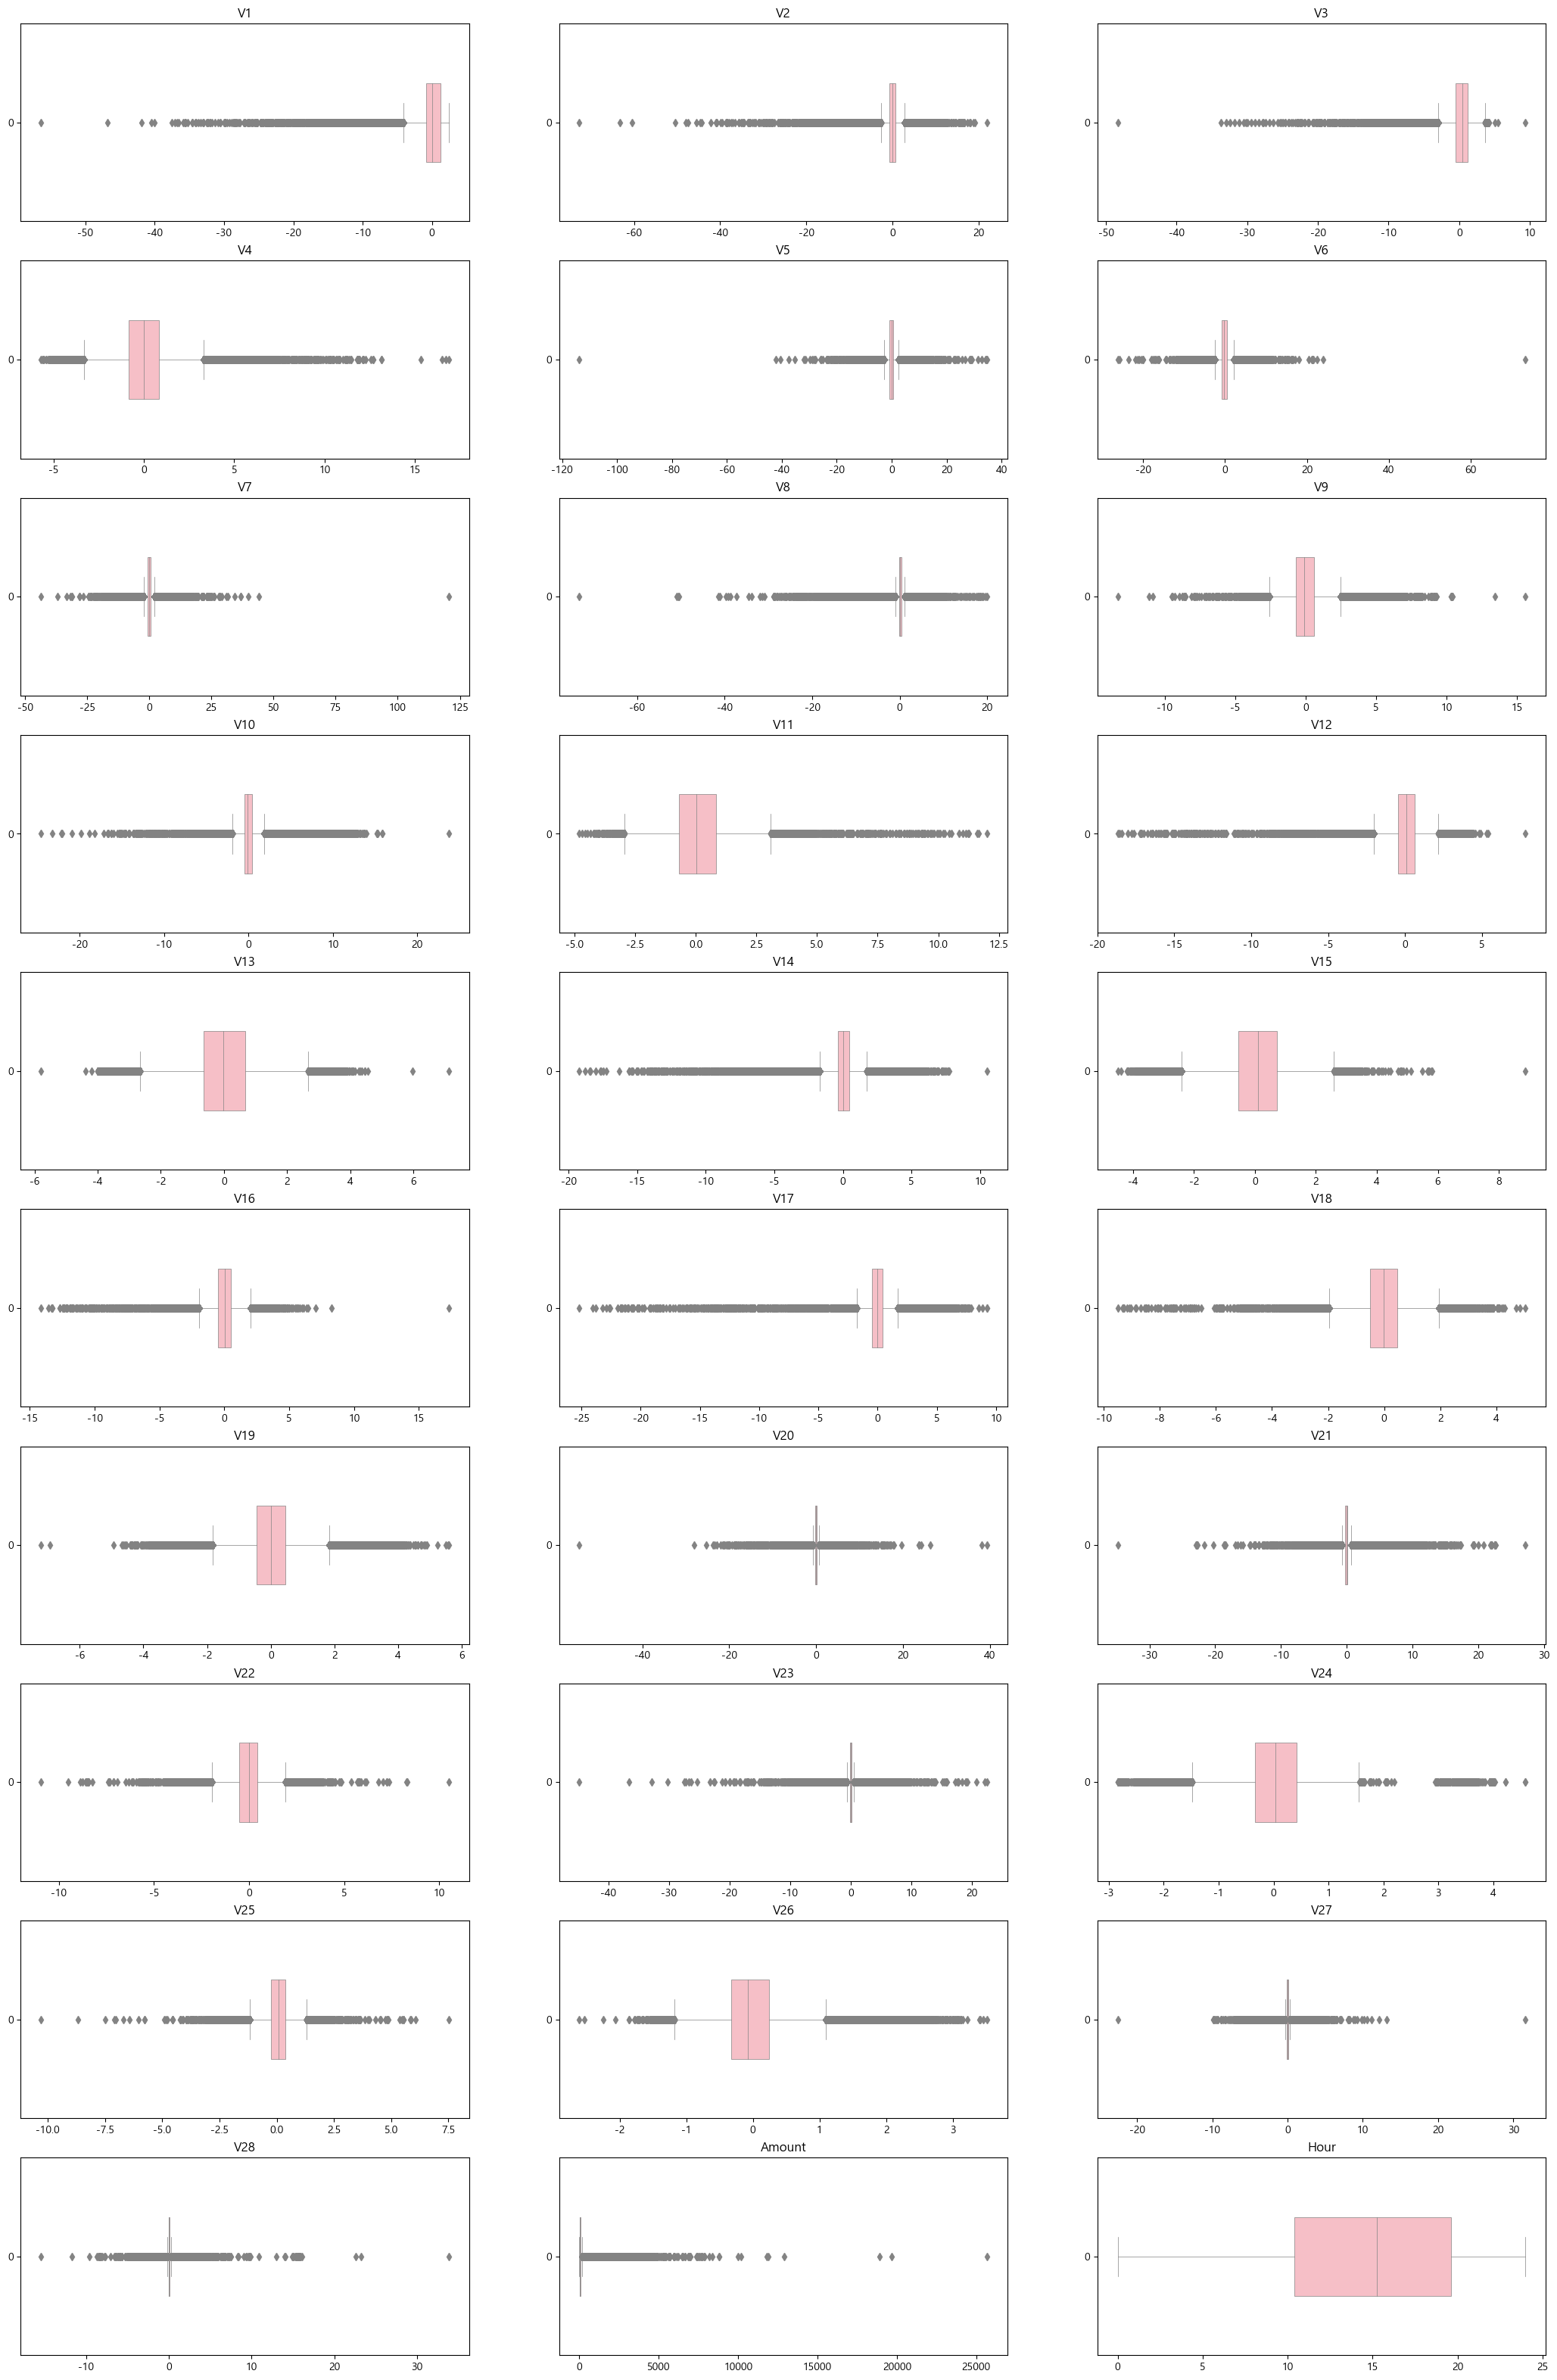

In [23]:
# Feature Boxplot 

temp = train_combined.drop(columns=['Class', 'early_morning', 'morning', 'afternoon', 'evening'], axis=1)
continuous_cols = temp.columns.tolist()

fig, axs = plt.subplots(figsize=(26, 40), nrows= 10, ncols=3)

for i,feature in enumerate(continuous_cols):
    row = int(i/3)
    col= i%3
    sns.boxplot(data=train_combined[feature], orient='h', color = "#FFB6C1", width=0.4, linewidth = 0.5, ax=axs[row][col])
    axs[row][col].set_title(feature)


Outlier 
1) 차원 축소된 V feature을 제외하고 'Amount'만 Robust Scaling
2) 이상치를 제거

In [24]:
# Outlier 찾는 detect_outliers 함수
def detect_outliers(df, features):
    for column in features:
        Q1 = np.quantile(df[column], 0.25)
        Q3 = np.quantile(df[column], 0.75)
        IQR = Q3-Q1
        boundary = 1.5*IQR
        
        outlier_list_column = df[(df[column] < Q1 - boundary)|(df[column] > Q3 + boundary)].index
        df = df.drop(outlier_list_column)
    return df

In [25]:
# Outlier를 제거한 train_combined_oulier_out 
train_combined_outlier_out = detect_outliers(train_combined, continuous_cols)
print("이상치 제거 전의 레코드 수: {}".format(train_combined.shape[0]))
print("이상치 제거 후의 레코드 수: {}".format(train_combined_outlier_out.shape[0]))
print("이상치 제거 시 약 {0:.2f}%의 레코드 삭제".format(train_combined_outlier_out.shape[0]*100/train_combined.shape[0]))

이상치 제거 전의 레코드 수: 499201
이상치 제거 후의 레코드 수: 204379
이상치 제거 시 약 0.41%의 레코드 삭제


1) Scaled Data 

In [26]:
# Train Data와 Test Data의 컬럼'Amount'만 Scaling

scaler = RobustScaler()
scaler.fit(train_combined[['Amount']])
train_combined[['Amount_Scaled']]= scaler.transform(train_combined[['Amount']])
test[['Amount_Scaled']] = scaler.transform(test[['Amount']])


In [27]:
train_combined.drop(columns=['Amount', 'Hour'], axis=1, inplace=True)
test.drop(['Amount', 'Hour'], axis=1, inplace=True)

Text(0.5, 1.0, "Train_Combined의 'Amount_Scaled'")

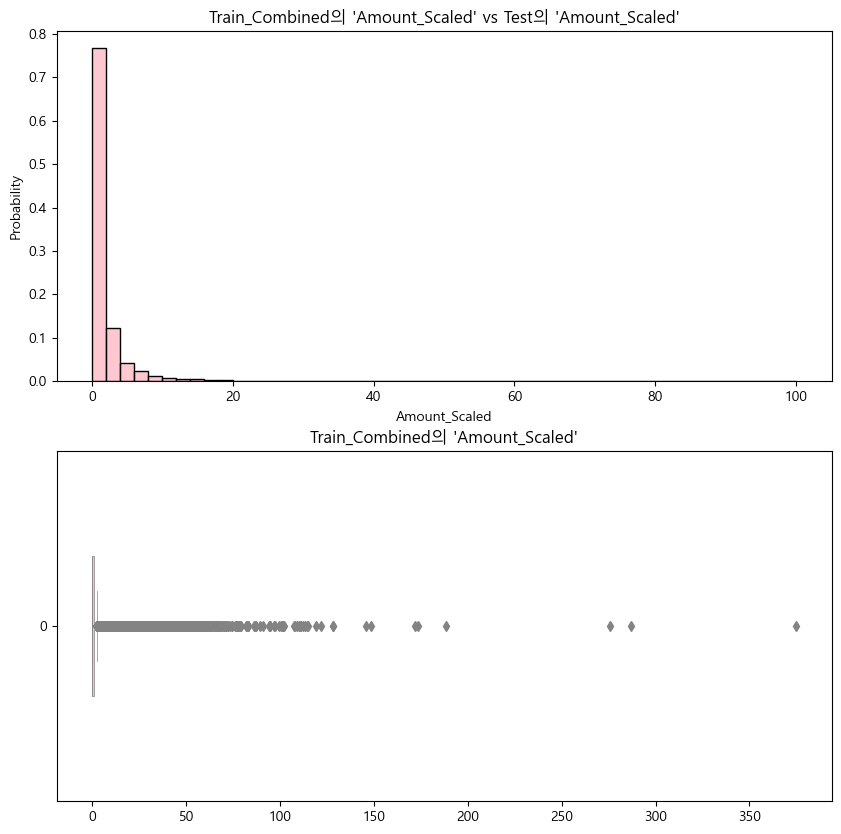

In [28]:
# Scaled 'Amount'

fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=1)

sns.histplot(data=train_combined['Amount_Scaled'], bins=50, binrange=(0, 100), stat='probability', color='#FFB6C1', ax=axs[0])
axs[0].set_title("Train_Combined의 'Amount_Scaled' vs Test의 'Amount_Scaled'")

sns.boxplot(data=train_combined['Amount_Scaled'], orient='h', color="#FFB6C1", width=0.4, linewidth=0.5, ax=axs[1])
axs[1].set_title("Train_Combined의 'Amount_Scaled'")


In [29]:
# csv 파일로 저장
train_combined.to_csv("train_scaled.csv", index=False)

2. 이상치 제거 

In [30]:
train_combined_outlier_out.to_csv("train_removed.csv", index=False)

결과

In [31]:
# 1. 이상치 스케일링
print("Scaled Data의 레코드 수: ", train_combined.shape[0])
print("Scaled Data의 Genuine Transaction(클래스 0): {}건".format(train_combined['Class'].value_counts()[0]))
print("Scaled Data의 Fraudulent Transaction(클래스 1): {}건".format(train_combined['Class'].value_counts()[1]))

Scaled Data의 레코드 수:  499201
Scaled Data의 Genuine Transaction(클래스 0): 498296건
Scaled Data의 Fraudulent Transaction(클래스 1): 905건


In [32]:
# 2. 이상치 제거
print("Removed Data의 레코드 수: ", train_combined_outlier_out.shape[0])
print("Removed Data의 Genuine Transaction(클래스 0): {}건".format(train_combined_outlier_out['Class'].value_counts()[0]))
print("Removed Data의 Fraudulent Transaction(클래스 1): {}건".format(train_combined_outlier_out['Class'].value_counts()[1]))

Removed Data의 레코드 수:  204379
Removed Data의 Genuine Transaction(클래스 0): 204282건
Removed Data의 Fraudulent Transaction(클래스 1): 97건
